<a href="https://colab.research.google.com/github/JulianSchmidtke/CAPTUM/blob/main/AsuD_CAPTUM_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk, os
import pandas as pd
import numpy as np
import re
from collections import Counter
import shutil

In [2]:
os.chdir(r'/content')

content_dir = r'/content/CAPTUM/'

# Remove if files already exist
while os.path.exists(content_dir): 
    shutil.rmtree(content_dir)


!git clone https://github.com/JulianSchmidtke/CAPTUM.git

Cloning into 'CAPTUM'...
remote: Enumerating objects: 547, done.
remote: Counting objects: 100% (547/547), done.
remote: Compressing objects: 100% (524/524), done.
remote: Total 547 (delta 42), reused 463 (delta 20), pack-reused 0
Receiving objects: 100% (547/547), 11.75 MiB | 8.95 MiB/s, done.
Resolving deltas: 100% (42/42), done.


# Duplikate unter den Papern entfernen anhand der Hash-Werte

In [3]:
#Arbeitsverzeichnis auf das Ordnerverzeichnis ändern, in welchem die Daten liegen (txt-Format)
file_dir = r'/content/CAPTUM/files'
os.chdir(file_dir)

#Speichern der Dateinamen in einem Array
files = os.listdir()
df_files = pd.DataFrame(files, columns=['Filepath'])

In [4]:
# create checksum for each file to identify duplicates
# https://stackoverflow.com/questions/16874598/how-do-i-calculate-the-md5-checksum-of-a-file-in-python#16876405
import hashlib
def get_checksum(filepath: str) -> str:
    # Open,close, read file and calculate MD5 on its contents 
    with open(filepath, 'rb') as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        return hashlib.md5(data).hexdigest()
df_files['Checksum'] = df_files['Filepath'].apply(get_checksum)

In [5]:
fileNameTags = list(map(lambda fn: fn.replace('', '+').split('_')[0:-2],df_files['Filepath']))


df_files['Name'] = [fNT[-1] for fNT in fileNameTags]
df_files['Tags'] = [fNT[1:-1] for fNT in fileNameTags]
df_files['Year'] = [fY[-8:-4] for fY in df_files['Name']]
df_files['Authors'] = [fN.split(' ')[0] for fN in df_files['Name']]

In [6]:
#Den Inhalt der Paper einlesen und in einen Pandas-
df_files['Content'] = df_files['Filepath'].apply(lambda f: open(f, 'r', encoding = "ISO-8859-1").read())
df_files

,Filepath,Checksum,Name,Tags,Year,Authors,Content
0,CAPTUM_Angioedema_Antihistamine_Büyüköztürk 20...,f1c33a85bccf2333444ee3510641276d,Büyüköztürk 2012.pdf,"[Angioedema, Antihistamine]",2012,Büyüköztürk,JAPANESE\n\nDERMATOLOGICAL\nASSOCIATION\n\n \n...
1,CAPTUM_Severity_Omalizumab_Baysak 2020.pdf_out...,d62e728a555e0fb6159cc7534d5b1edb,Baysak 2020.pdf,"[Severity, Omalizumab]",2020,Baysak,Long-term follow-up effect of omalizumab in ch...
2,CAPTUM_TPO_Thyroglobulin_Gangemi 2009.pdf_out_...,b95cca90d19a65d473854603062f3923,Gangemi 2009.pdf,"[TPO, Thyroglobulin]",2009,Gangemi,"J. Endocrinol. Invest. 32: 107-110, 2009\n\nSe..."
3,CAPTUM_Angioedema_Antihistamine_Hofman 2020.pd...,e8b7fe09fb6b8069ad49406b65949f76,Hofman 2020.pdf,"[Angioedema, Antihistamine]",2020,Hofman,| ®\nReceived: 7 June 2019 Revised: 12 Decembe...
4,CAPTUM_Severity_Tissue factor_Asero 2007.pdf_o...,8fc28946e318d647a4533f80f38d7a75,Asero 2007.pdf,"[Severity, Tissue factor]",2007,Asero,"Food allergy, anaphylaxis, dermatology, and dr..."
...,...,...,...,...,...,...,...
1041,CAPTUM_Basophil_Antihistamine_Kim 2016.pdf_out...,58c4b83abea873226cc388588866c20e,Kim 2016.pdf,"[Basophil, Antihistamine]",2016,Kim,OZ0z/SO/11 Uo =361SH98A 4Z>IBE GAMA VOLPO NEIO...
1042,CAPTUM_ASST_serverity_Pathania 2019.pdf_out_...,2902b652fbb15995ca2402871eb3b2e4,Pathania 2019.pdf,"[ASST+, serverity+]",2019,Pathania,World Allergy Organization Journal 12 (2019) 1...
1043,CAPTUM_ASST_serverity_Chang 2019.pdf_out_tex...,848f12d7e5b811838c69dd73ef66da87,Chang 2019.pdf,"[ASST+, serverity+]",2019,Chang,Taylor & Francis\nTaylor & Francs Group\n\nJou...
1044,CAPTUM_Anti-IgE_IL-24_Schmetzer 2017.pdf_out_t...,ddd3809b19f3e4930b7aadd99fd287a3,Schmetzer 2017.pdf,"[Anti-IgE, IL-24]",2017,Schmetzer,"Anaphylaxis, drug allergy, urticaria, and angi..."


In [7]:
checksums = df_files['Checksum'].unique()
for checksum in checksums:
    tags = df_files.loc[df_files['Checksum'] == checksum, 'Tags']
    list_of_pair_of_tags = tags.values.ravel()
    list_of_tags = [tag for tags in list_of_pair_of_tags for tag in tags]
    unique_tags = pd.unique(list_of_tags)
    df_files.loc[df_files['Checksum'] == checksum, 'Tags'] = ', '.join(map(str, unique_tags))

In [8]:
# create dataframe for further analytics w/o the duplicate articles
df = df_files.drop_duplicates(subset=['Checksum'], keep='first')
df.reset_index(inplace=True, drop=True)
df = df.loc[:,['Authors','Year','Tags', 'Content']]

# Korpus erstellen

In [9]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Es werden Füllwörter entfernt.

In [10]:
stop_words=set(stopwords.words("english"))
def stoppingFunc(text, stop_words=stop_words):
    filtered_text=[]
    for word in text:
        # Wort unter 3 Zeichen -> weg
        if len(word) < 3:
          next
        # Mehr als eine Ziffer -> weg
        elif sum(c.isdigit() for c in word)>1:
          next
        # nicht in Stopword Liste -> behalten
        elif word not in stop_words:
          filtered_text.append(word)
        
    return filtered_text

Wörter auf ihren Wortstamm reduzieren (cats -> cat, transportation -> transport)

In [11]:
def stemmingFunc(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text]

Komplexere Version des Stemming. Wörter werden im Zusammenhang gesehen und reduziert. Verben werden auf den Infiitiv gesetzt usw.

In [12]:
def lemmatizingFunc(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [13]:
def removeWords(text):
  filtered_text=[]
  for word in text:
    if word.lower() in ('csu', 'urticaria', 'doi', 'http', 'the', 'al', 'fig', 
                        'point', 'data', 'patient', 'result', 'study', 'disease', 
                        'result', 'group', 'table', 'figure', 'patient'):
      next
    else:
      filtered_text.append(word)

  counter = Counter(filtered_text)
  filtered_text = [key for key, val in counter.items() if val > 1]

  return filtered_text

In [14]:
def remove_doi(text):
  doi_regex = r"10.\d{4,9}\/[-._;()\/:A-Z0-9]+$"
  new_text = re.sub(doi_regex, '', text, flags=re.IGNORECASE)
  return new_text

In [15]:
removeWords(['csu', 'TEST', 'DOI', 'doi', 'al', 'DOI'])

[]

In [16]:
def normalize_text(tokenizer, text):
  # lowercase text
  text = str(text).lower()
  # remove non-UTF
  text = text.encode("utf-8", "ignore").decode()
  # remove doi
  text = remove_doi(text)

  tokenized_text = tokenizer.tokenize(text)

  tokenized_text = removeWords(tokenized_text)
  tokenized_text = stoppingFunc(tokenized_text)
  #tokenized_text = stemmingFunc(tokenized_text)
  tokenized_text = lemmatizingFunc(tokenized_text)

  text = " ".join(tokenized_text)
  return text

In [17]:
def remove_word_in_every_corpus(corpus, series):
  words = set(series)
  print(words)
  return




  new_corpus = []
  for word in corpus:
    in_every_corpus = True
    for element in series:
      if not word in element:
        in_every_corpus = False
    if in_every_corpus:
      new_corpus += word
  return new_corpus

Ich glaube es sollte entweder eine Stemming oder eine Lemmatizing Funktion angewendet werden.

Ich glaube wir sollten erst Lemmatizen und dann Stopwords entfernen.

In [18]:
regex_tokenizer = nltk.RegexpTokenizer("\w+")
df['Corpus'] = df['Content'].apply(lambda c: normalize_text(regex_tokenizer, c))

# Corpus aufräumen 
#df['Corpus'] = df['Corpus'].apply(lambda c: remove_word_in_every_corpus(c, df['Content']))


regex_tokenizer2 = nltk.RegexpTokenizer('\w+[\.,]{0,1}')
df['Corpus_w_Punctuation'] = df['Content'].apply(lambda c: normalize_text(regex_tokenizer2, c))


In [19]:
corpus_list = df['Content'].to_list()
remove_word_in_every_corpus('', corpus_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
df

,Authors,Year,Tags,Content,Corpus,Corpus_w_Punctuation
0,Büyüköztürk,2012,"Angioedema, Antihistamine, Severity, Omalizumab",JAPANESE\n\nDERMATOLOGICAL\nASSOCIATION\n\n \n...,japanese dermatological association dermatolog...,japanese dermatological association dermatolog...
1,Baysak,2020,"Severity, Omalizumab, CRP",Long-term follow-up effect of omalizumab in ch...,long term follow effect omalizumab chronic spo...,long term follow effect omalizumab chronic spo...
2,Gangemi,2009,"TPO, Thyroglobulin, Duration","J. Endocrinol. Invest. 32: 107-110, 2009\n\nSe...",endocrinol invest serum thyroid autoantibody p...,endocrinol. invest. serum thyroid autoantibody...
3,Hofman,2020,"Angioedema, Antihistamine, Severity",| ®\nReceived: 7 June 2019 Revised: 12 Decembe...,received revised december cea original article...,received revised december cea. original articl...
4,Asero,2007,"Severity, Tissue factor, D-Dimer","Food allergy, anaphylaxis, dermatology, and dr...",allergy dermatology drug activation tissue fac...,"allergy, drug allergy activation tissue factor..."
...,...,...,...,...,...,...
449,Kasumagic-Halilovic,2017,"TPO, Thyroglobulin",Published online:05/02/2017\n\nORIGINAL PAPER\...,published original paper med arch feb accepted...,published original paper med arch. feb accepte...
450,Altrichter,2020,"Eosinophil, Allergic Diseases",Current perspectives\n\nThe role of eosinophil...,role eosinophil chronic spontaneous update alt...,"role eosinophil chronic spontaneous update md,..."
451,Sánchez,2019,"TPO, Severity",Hindawi\n\nJournal of Immunology Research\n\nV...,journal immunology research article page clini...,journal immunology research article clinical c...
452,Asero,020,"D-Dimer, Omalizumab",CHRONIC SPONTANEOUS URTICARIA TREATED WITH OMA...,chronic spontaneous treated omalizumab early l...,chronic spontaneous treated omalizumab early l...


# Wordcloud


In [ ]:
!pip install wordcloud

from wordcloud import WordCloud

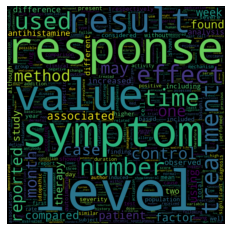

In [ ]:
words = ' '.join(list(df['Corpus']))
wordcloud = WordCloud(width=1000, height=1000, max_words=1000).generate(words)
wordcloud.to_file("../../first_review.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Distinct Tags

In [ ]:
type(list(df['Tags']))
tags = set(', '.join(list(df['Tags'])).split(', '))
print(*tags, sep="\n")

Angioedema
Antihistamine
Omalizumab
Anti-IgE
Severity
Total IgE
TPO
anti-FcεRI
Ana
ASST+
CRP
serverity+
duration
Basophil count
BAT
Eosinophil count
Tissue factor
omalizumab
Duration
thyroglobulin
Allergic Diseases
dsDNA
Thyroglobulin
angioedema
anti-TPO IgE ratio+
Basophil
BHRA
Cyclosporine
D-Dimer
IL-24
cyclosporine
Eosinophil
ANA


# Algorithmen anwenden

### ScispaCy

In [21]:
!pip install spacy==3.1.0
!pip install scispacy==0.4.0
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz

     |████████████████████████████████| 6.4 MB 3.8 MB/s 
     |████████████████████████████████| 621 kB 43.6 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 456 kB 26.5 MB/s 
     |████████████████████████████████| 10.1 MB 47.9 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 44 kB 1.1 MB/s 
     |████████████████████████████████| 71 kB 3.

In [22]:
import spacy
import scispacy

from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.linking import EntityLinker
from collections import OrderedDict, Counter
from pprint import pprint


In [24]:

def display_entities(model, document):
  doc = nlp(document)
  displacy_image = displacy.render(doc, jupyter=True, style='ent')
  entity_and_label = set([(X.text, X.label_) for X in doc.ents])
  return displacy_image, entity_and_label

In [25]:
#As an example print the first Corpus from the df with the recogniced entities.
nlp = spacy.load('en_ner_bionlp13cg_md')
entities = display_entities(nlp, df['Corpus_w_Punctuation'][0])

In [26]:
entities_dataframe = pd.DataFrame(entities[1],columns=['Entity','Label'])
entities_dataframe

,Entity,Label
0,skin,ORGAN
1,immunoglobulin fceri surface mast,GENE_OR_GENE_PRODUCT
2,cell noga,CELLULAR_COMPONENT
3,corticosteroids,SIMPLE_CHEMICAL
4,line,CELL
5,patients,ORGANISM
6,corticosteroid frequent must angioedema,SIMPLE_CHEMICAL
7,omalizumab,SIMPLE_CHEMICAL
8,thyroid peroxidase,CANCER
9,antihistamine first,GENE_OR_GENE_PRODUCT


In [27]:
def entity_linker(linker_name,document):
  """A function tha accepts the name of a scispacy knowledgebase and 
  documents and returns the entity link details"""
  
  doc = nlp(document)
  try: 
    entity = doc.ents[0]
  except IndexError:
    entity = 'NaN'
  entity_details = []
  entity_details.append(entity)
  try:
    for linker_ent in entity._.kb_ents:
      Concept_Id, Score = linker_ent
      entity_details.appen('Entity_matching_Score :{}'.format(Score))
      entity_details.append(linker.kb.cui_to_entity[linker_ent[linker_ent[0]]])
  except AttributeError:
    pass
  return entity_details

In [ ]:
nlp = spacy.load('en_ner_bionlp13cg_md')
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"}) #parameters are tunable, so it can be set to return more than 2 entity matches.
doc = df['Corpus_w_Punctuation'][0]
doc = nlp(doc)

entity = doc.ents[0]

linker = nlp.get_pipe("scispacy_linker")
for ent in entity._.kb_ents:
	print(linker.kb.cui_to_entity[ent[0]])


## Bag of Words
Quelle: [towardsdatascience](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [ ]:
import gensim
import numpy as np
np.random.seed(2021)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
processed_docs = df['Corpus'].apply(lambda c: c.split(' '))

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 _http
1 aair
2 aairorg
3 able
4 academy
5 accepted
6 according
7 achieve
8 achieved
9 achieving
10 acta


### **LDA** (LatentDirichletAllocation) 
Quelle: [Medium-Artikel zu LDA](https://towardsdatascience.com/nlp-with-lda-latent-dirichlet-allocation-and-text-clustering-to-improve-classification-97688c23d98)

In [ ]:
#Turn tags into a set for faster checking of whether a tag exists or not
type(list(df['Tags']))
unique_tags = set(', '.join(list(df['Tags'])).split(', '))
print(*unique_tags, sep="\n")


Angioedema
Antihistamine
Omalizumab
Anti-IgE
Severity
Total IgE
TPO
anti-FcεRI
Ana
ASST+
CRP
serverity+
duration
Basophil count
BAT
Eosinophil count
Tissue factor
omalizumab
Duration
thyroglobulin
Allergic Diseases
dsDNA
Thyroglobulin
angioedema
anti-TPO IgE ratio+
Basophil
BHRA
Cyclosporine
D-Dimer
IL-24
cyclosporine
Eosinophil
ANA


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA


def find_topics(text):
  count_vectorizer = CountVectorizer()
  count_data = count_vectorizer.fit_transform(list(text))


  # One topic that has an avg of two words because most questions had 1/2 tags
  number_topics = 5
  number_words = 20

  # Create and fit the LDA model
  lda = LDA(n_components=number_topics, n_jobs=-1)
  lda.fit(count_data)
  words = count_vectorizer.get_feature_names()

  #Get topics from model. They are represented as a list e.g. ['military','army']
  topics = [[words[i] for i in topic.argsort()[:-number_words - 1:-1]] for (topic_idx, topic) in enumerate(lda.components_)]
  topic_groups = topics

  topics = np.array(topics).ravel()
  distinct_topics = list(set(topics))

  #Only use topics for which a tag already exists
  existing_topics = set.intersection(set(topics),unique_tags)

  

  return (words, distinct_topics, topic_groups, existing_topics)

In [ ]:
words, distinct_topics, topic_groups, existing_topics = find_topics(df['Corpus_w_Punctuation'])

In [ ]:
sorted(distinct_topics)


['activation',
 'activity',
 'airway',
 'allergy',
 'analysis',
 'angioedema',
 'antibody',
 'antihistamine',
 'asst',
 'asthma',
 'basophil',
 'cell',
 'cells',
 'cohort',
 'concentration',
 'confidence',
 'content',
 'control',
 'correlation',
 'difference',
 'dimension',
 'disease',
 'dose',
 'dosing',
 'education',
 'effect',
 'eosinophil',
 'factor',
 'function',
 'ige',
 'individual',
 'inflammation',
 'level',
 'lloq',
 'male',
 'manuscript',
 'mechanism',
 'mediated',
 'medimmune',
 'method',
 'model',
 'month',
 'mouse',
 'national',
 'omalizumab',
 'pathway',
 'patient',
 'patients',
 'placebo',
 'plate',
 'process',
 'protein',
 'psoriasis',
 'reaction',
 'receptor',
 'respectively',
 'response',
 'scale',
 'score',
 'screening',
 'secretion',
 'serum',
 'severity',
 'skin',
 'standard',
 'study',
 'subject',
 'symptom',
 'syndrome',
 'test',
 'therapy',
 'treatment',
 'type',
 'urticaria',
 'virginia',
 'week',
 'year']

### **BERTopic** 
Topic modeling mit BERTopic -> siehe: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Copy and Paste aus: https://colab.research.google.com/drive/1iqs9Y5_zLI6R6mAwlnapcxcUbKjpv2CC?usp=sharing#scrollTo=MgMaef_uZT0T
bzw.: https://www.youtube.com/watch?v=TLPmlVeEf1k

In [ ]:
!pip3 install bertopic[all]
from bertopic import BERTopic

^C


ModuleNotFoundError: ignored

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, _ = topic_model.fit_transform(list(df['Content']))

In [ ]:
# Get the most frequent topics
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} documents have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

In [ ]:
topic_freq.head()

In [ ]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

In [ ]:
topic_model.get_topic(topic_freq['Topic'].iloc[1])

In [ ]:
topic_model.visualize_topics()

### **DistilBert**
Quelle: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(df['Content'], show_progress_bar=True)

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=4,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.colorbar()

### Top2Vec

Quelle: https://github.com/bhattbhavesh91/Top2Vec-Demo/blob/main/Top2Vec-Notebook.ipynb

In [ ]:
!pip install -q numpy
!pip install -q pandas
!pip install -q gensim
!pip install -q pynndescent>=0.4
!pip install -q umap-learn
!pip install -q hdbscan
!pip install -q wordcloud
!pip install -q tensorflow
!pip install -q tensorflow_hub
!pip install -q tensorflow_text
!pip install -q torch
!pip install -q sentence_transformers
!pip install -q hnswlib
!pip install -q joblib<1.0.0
!pip install -q top2vec[sentence_transformers]

     |████████████████████████████████| 80 kB 8.7 MB/s 
     |████████████████████████████████| 6.4 MB 40.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.3 MB 29.9 MB/s 
     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 2.6 MB 28.4 MB/s 
     |████████████████████████████████| 1.2 MB 42.3 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 3.3 MB 39.9 MB/s 
     |████████████████████████████████| 895 kB 40.5 MB/s 
     |████████████████████████████████| 636 kB 20.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
/bin/bash: 1.0.0: No such file or directory


In [ ]:
import numpy as np
import pandas as pd
from copy import deepcopy
from top2vec import Top2Vec

In [ ]:
docs = list(df.loc[:, "Content"].values)
docs[:5]

In [ ]:
model = Top2Vec(docs, embedding_model='universal-sentence-encoder')

In [ ]:
model.get_num_topics()

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(1)

In [ ]:
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

### TFIDF Vertorizer

In [ ]:
#@title Dateiinhalt, Korpus oder Korpus mit Satzzeichen
src = 'Corpus_w_Punctuation' #@param {type:"string"}
tfidfconvert = TfidfVectorizer(ngram_range=(1,1)).fit(df[src].values)

In [ ]:
len(tfidfconvert.vocabulary_)

15875

In [ ]:
words_transformed = tfidfconvert.transform(df['Corpus'].values)

### K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans

K-Means für mehrere k's berechnen und anschließend plotten

In [ ]:
Sum_of_squared_distances = []
max_range = 10
K = range(1,max_range + 1)
for k in K: 
    print(str(k) + "/" + str(max_range))
    km = KMeans(n_clusters=k)
    km = km.fit(words_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


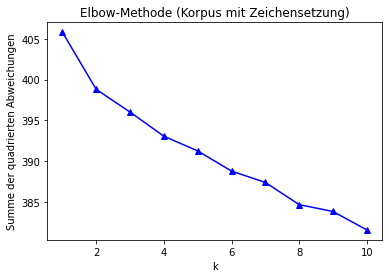

In [ ]:
plt.plot(K,Sum_of_squared_distances, 'b^-')
plt.xlabel('k')
plt.ylabel('Summe der quadrierten Abweichungen')
plt.title('Elbow-Methode (Korpus mit Zeichensetzung)')
plt.show()

Wortsammlungen erstellen durch angabe der Idealen Clusterzahl im Formularfeld

In [ ]:
#@title Anzahl der Cluster gem. Elbow-Curve
k = 2#@param {type:"integer"}

km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1,
                verbose=1)

In [ ]:
#https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html
km = km.fit(words_transformed)
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidfconvert.get_feature_names()

clustered_words = []
for i in range(k):
  words_per_cluster = []
  for ind in order_centroids[i, :20]:
    words_per_cluster.append(terms[ind])
  clustered_words.append(words_per_cluster)

Initialization complete
Iteration  0, inertia 792.049
Iteration  1, inertia 403.922
Iteration  2, inertia 403.322
Iteration  3, inertia 402.123
Iteration  4, inertia 400.930
Iteration  5, inertia 400.069
Iteration  6, inertia 399.599
Iteration  7, inertia 399.340
Iteration  8, inertia 399.208
Iteration  9, inertia 399.119
Iteration 10, inertia 399.066
Iteration 11, inertia 399.026
Iteration 12, inertia 398.991
Iteration 13, inertia 398.976
Converged at iteration 13: center shift 0.000000e+00 within tolerance 5.630529e-09


In [ ]:
#clustered_words Liste transponieren
clustered_words = list(map(list, zip(*clustered_words)))

#Dataframe aus clustered_words erstellen
cluster_names = ['Cluster %s' %i for i in range(1,k+1)]
df_clustered_words = pd.DataFrame(data=clustered_words, columns=cluster_names)
df_clustered_words

,Cluster 1,Cluster 2
0,cell,antihistamine
1,basophil,week
2,control,month
3,factor,score
4,test,guideline
5,level,trial
6,antibody,effect
7,serum,symptom
8,wheal,day
9,difference,therapy




# **IDEEN zum Cluster bilden**


- Bag of Words kreiren um neuer Cluster / Wortgruppen zu finden über Häufigkeit der Wörter oder nähe der Wörter zu einander
- Visualisieren des Links zwischen Markern in einer HeatMap
- BioBert einsetzen
- Part of Speech recognition um Autorennamen zu identifizieren 
- AutorenNamen und Marker verknüpfen / clustern
- 


**Generelle Todo's**
- Distinct Values für Abkürzungsverzeichnis erheben und mit Markern abgleichen
- CRISP-DM als Vorgehensmoddel zugrundeliegen
- Begründen Stemm / Lemmatizing - Erörterung im Paper